
<p>
<font size="5"  face="Arial"><strong>Sklearn</strong></font>

<p>Bike Sharing Demand</p>

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной постановке задачи доступно 11 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные.

Для демонстрации используется обучающая выборка из исходных данных train.csv, файлы для работы прилагаются
</p>

<p><strong>Библиотеки</strong></p>
<p>cross_validation</strong>- разбивка выборки на test и train </p>
<p><strong>grid_search</strong> - перебор параметров для заданного классификатора </p>
<p><strong>linear_model</strong> - линейная регрессия </p>
<p><strong>linear_model</strong> - позволяет выполнить последовательную обработку данных в одной команде </p>
<p><strong>preprocessing</strong> - предобработка, нормировка данных </p>

In [ ]:
from sklearn import cross_validation, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<p><strong>Загрузка данных</strong></p>
<p><strong>pd.read_csv</strong> позволяет читать файлы формата csv, полное описание
 <a href="1.html">https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html </a> </p>
<p><strong>путь к файлу, header = 0</strong> указывается что 0-я строка является заголовками,<strong> sep</strong>  - используемый разделитель</p>

In [3]:
raw_data = pd.read_csv('train.csv', header = 0, sep = ',')

In [4]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<p><strong>pd.to_datetime</strong> - конвертация в тип дата/время</p>
<p><strong>apply</strong> - применение указанной функции в скобках к каждой строке dataframe</p>

In [4]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)


<p><strong>Задаем отдельно признаки месяц, час, год, день недели </strong></p>
<p><strong>lambda</strong> - упрощенное задание функции, *args (передаваемые аргументы): используемая функция </p>
<p><strong>.month</strong> - для объекта типа дата/время извлекает месяц, .hour - час,  - год, .weekday() - день недели </p>

In [5]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)
raw_data['year'] = raw_data.datetime.apply(lambda x : x.year)
raw_data['week_day'] = raw_data.datetime.apply(lambda x : x.weekday() + 1)

<p><strong>Разделяем на train и test </strong></p>

In [6]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [7]:
print(raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 16) (9886, 16) (1000, 16)


<p><strong>Определение таргета и объясняющих переменных для модели на тесте и трейне  </strong></p>
<p>1)Задаем таргет </p>
<p>2)Удаляем прогнозируемые переменные с датафрейма </p>

In [8]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

In [11]:
#тест
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count', 'casual', 'registered'], axis = 1)

<p><strong>Определяем бинарные переменные </strong></p>
<p>Задаем массив binary_data_columns, в котором указываем какие столбцы относятся к бинарным переменным</p>
<p>Массив binary_data_indices, в котором true - указанная переменная с соответствующим порядковым номером бинарная, false - нет </p>

In [12]:
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

In [13]:
print(binary_data_columns)
print(binary_data_indices) 

['holiday', 'workingday']
[False  True  True False False False False False False False False False]


<p><strong>Определяем категориальные переменные </strong></p>

In [14]:
categorical_data_columns = ['season', 'weather', 'month', 'week_day'] 
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

<p><strong>Определяем числовые переменные </strong></p>

In [15]:
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', 'year']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

<p><strong>Задаем  линейную модель для обучения (с использованием стохастического градиентного спуска для минимизации 
    заданной ф-и потерь) </strong></p>
<p><strong>loss </strong> - определяем функцию потерь, <strong>  penalty  </strong> - регуляризация </p>

In [16]:
regressor = linear_model.SGDRegressor(random_state = 0, n_iter = 3, loss = 'squared_loss', penalty = 'l2')

<p><strong>Pipeline</strong></p>
<p><strong> В Pipeline определяем последовательность действий для предобработки данных </strong></p>
<p><strong>1.</strong>Для бинарных переменных предобработка не нужна</p>
<p><strong>2.</strong>Выбираем числовые переменные и используем z-score normalization</p>
Материал для самостоятельного изучения  <a href="1.html">https://en.wikipedia.org/wiki/Standard_score </a>
<p><strong>3.</strong>Выбираем категориальные  переменные и используем преобразование </p>
в dummy -переменные с помощью OneHotEncoder.
Подробный разбор
<a href="1.html">http://qaru.site/questions/845190/explain-onehotencoder-using-python</a>

In [17]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean=False))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

<p><strong>Обучаем модель </strong></p>

In [18]:
estimator.fit(train_data, train_labels)

C:\Users\Mary\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000027AB7D821E0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

<p><strong>Считаем MAE на тестовых данных </strong></p>
Про MAE
<a href="1.html">https://en.wikipedia.org/wiki/Mean_absolute_error</a>

In [19]:
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

6204156974730836.0

<p><strong>Подбор параметров</strong></p>
<p>1. Смотрим какие параметры можно задать для SGDRegressor</p>

In [20]:
regressor.get_params().keys()

dict_keys(['alpha', 'average', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'verbose', 'warm_start'])

In [ ]:
estimator.get_params()

<p><strong>Задаем параметры для оптимизации в словаре</strong></p>
<p><strong>alpha </strong> - множитель перед функцией регуляризации</p>
<p><strong>eta0 </strong> - начальная learning rate</p>
<p><strong>loss </strong> - выбранная функция потерь</p>
<p><strong>penalty </strong> - регуляризация</p>

In [22]:


parameters_grid = {
    'model_fitting__alpha' : [0.0001, 0.001, 0,1],
    'model_fitting__eta0' : [0.001, 0.05],
    'feature_processing__numeric_variables_processing__scaling__with_mean' : [True, False],
    'model_fitting__loss' : ['squared_loss', 'huber'],
    'model_fitting__penalty' : ['l1', 'l2'],
}



<p><strong>Перебор гиперпатаметров для заданного классификатора</strong></p>
<p><strong>estimator </strong> - sgd regressor</p>
<p><strong>parameters_grid </strong> - оптимизируемые параметры</p>
<p><strong>'mean_absolute_error' </strong> - выбранная метрика оптимизации</p>


In [23]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring = 'mean_absolute_error', cv = 4)

In [ ]:
%%time
grid_cv.fit(train_data, train_labels)

<p><strong>Выводим результаты по всем моделям, которые были определены 
по сетки перебора параметров и полученный score</strong></p>

In [ ]:
grid_cv.grid_scores_

<p><strong>Топ</strong></p>

In [26]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-106.04262605670905
{'feature_processing__numeric_variables_processing__scaling__with_mean': True, 'model_fitting__alpha': 1, 'model_fitting__eta0': 0.05, 'model_fitting__loss': 'squared_loss', 'model_fitting__penalty': 'l1'}


In [30]:
grid_cv.best_estimator_

Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000027AB7D821E0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ...,
       power_t=0.25, random_state=0, shuffle=True, tol=None, verbose=0,
       warm_start=False))])

<p><strong>Оценка по отложенному тесту</strong></p>
<p><strong>Предсказываем, считаем mae, рисуем график предсказанных значений и таргета на тестовой выборке</strong></p>


In [31]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [32]:
metrics.mean_absolute_error(test_labels, test_predictions)

126.69258549981593

In [33]:
print(test_labels[:20])

[525 835 355 222 228 325 328 308 346 446 943 838 531 432 195 181 199  49
  17  16]


In [34]:
print(test_predictions[:20])

[229.51686864 253.18241656 294.20356421 324.23340384 340.37564513
 332.56214672 359.86923706 386.72184116 391.07495037 401.95792886
 400.65426805 393.93558749 378.44307042 363.63776233 353.78872361
 324.19615326 329.99971467 142.8902929  150.24887704 157.60746119]


In [41]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


<p><strong>На графике</strong></p>
<p>Ось X  - таргет, Ось Y  - спрогнозированные значения,<strong> синий</strong> - обучающая выборка, <strong>красный</strong> - тестовая</p>

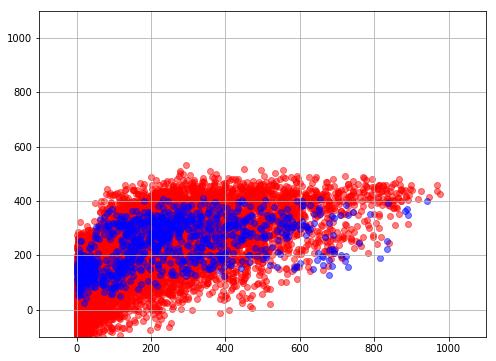

In [44]:
pylab.figure(figsize=(8, 6))
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')

<p><strong>Выводы</strong></p>
<p><strong>1.</strong>MAE высокий</p>
<p><strong>2.</strong>По графику видно, что прогноз не достаточно точный
(стремимся к линии под углом 45, то есть и спрогнозированные и реальные значения приблизительно одинаковые)</p>
<p><strong>3.</strong>Попробуем построить еще одну модель</p>

<p><strong>Random forest classifier</strong></p>


In [54]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\Mary\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<p><strong>Количество деревьев 50</strong></p>


In [55]:
regressor = RandomForestRegressor(random_state = 0, n_estimators = 50)

<p><strong>Переопределяем estimator для RF</strong></p>
<p><strong> Последовательность действий та же самая, только другая модель </strong></p>

In [56]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
        ])),
    ('model_fitting', regressor)
    ]
)

<p><strong>Обучаем модель на train</strong></p>


In [57]:
%%time
estimator.fit(train_data, train_labels)

Wall time: 39.4 s


Pipeline(memory=None,
     steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x0000027AB8272EA0>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
         ..._estimators=50, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

<p><strong>Считаем MAE</strong></p>

In [63]:

metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

46.47475033333334

In [58]:
len(regressor.feature_importances_)

35

In [59]:
test_labels[:10]

array([525, 835, 355, 222, 228, 325, 328, 308, 346, 446], dtype=int64)

In [60]:

estimator.predict(test_data)[:10]



array([406.64, 701.66, 347.3 , 175.26, 261.2 , 285.3 , 292.52, 294.82,
       315.44, 495.8 ])

<p><strong>Аналогично рисуем график</strong></p>

Text(0.5,1,'random forest model')

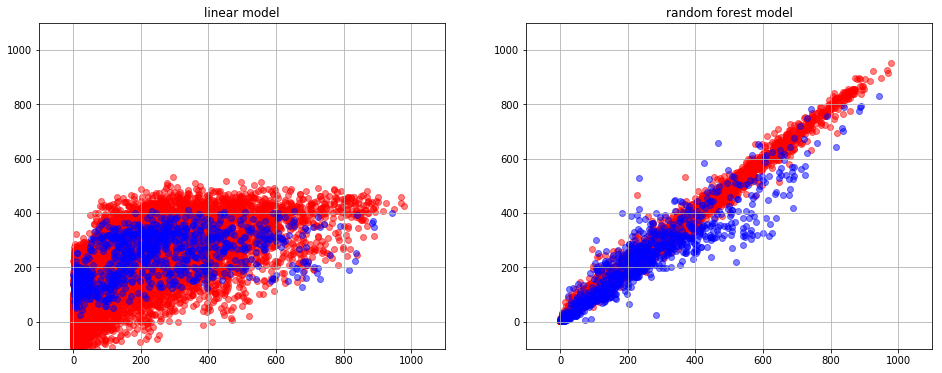

In [61]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('linear model')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('random forest model')

<p><strong>Выводы</strong></p>
<p><strong>RF</strong> показал явное преимущество перед <strong>SGD</strong>, 
MAE ниже в 2 раза и на графике видно, что предсказанные значения RF имеют меньшую погрешность
(явно вырисовывается линия под углом 45)</p>
